# Proyecto 2 - Contador Leucocitos
### Luna Durán - Alejandro García

In [22]:
# Librerias
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score

In [23]:
#importar imagenes 

# imagenes
img1 = cv2.imread('Image_1.png')
img2 = cv2.imread('Image_2.png')
img3 = cv2.imread('Image_3.png')

#mascaras manuales
img1_mask = cv2.imread('Image_1_mask.png')
img2_mask = cv2.imread('Image_2_mask.png')
img3_mask = cv2.imread('Image_3_mask.png')

### Contrast stretching

El contraste stretching (también conocido como estiramiento de contraste) es una técnica utilizada en procesamiento de imágenes digitales para mejorar el contraste de una imagen. La técnica se basa en la ampliación del rango de valores de los píxeles en una imagen para que los valores de píxeles oscuros sean más oscuros y los valores de píxeles claros sean más claros.

El contraste stretching se realiza mediante una transformación lineal de los valores de píxeles de una imagen. Esta transformación ajusta el valor mínimo y máximo de los píxeles en la imagen a un rango deseado, a menudo de 0 a 255, lo que se conoce como normalización. Esto puede mejorar la visualización de detalles y texturas en una imagen y hacer que la imagen sea más clara y fácil de interpretar.

OpenCV no tiene una funcion para hacer contrast stretching por lo que creamos una usando de base informacion encontrada en:
https://www.geeksforgeeks.org/python-blood-cell-identification-using-image-processing/

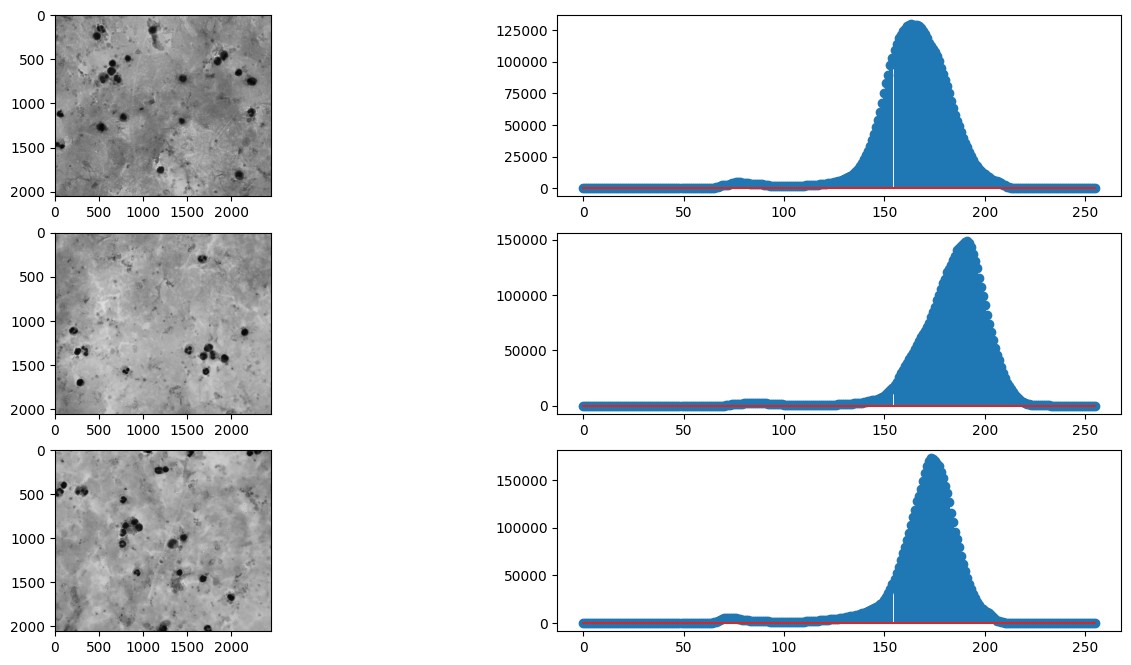

In [24]:
#analisis de histogramas
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
hist_gray = cv2.calcHist([img1_gray], [0], None, [256], [0, 256])
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
hist2_gray = cv2.calcHist([img2_gray], [0], None, [256], [0, 256])
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
hist3_gray = cv2.calcHist([img3_gray], [0], None, [256], [0, 256])

plt.figure(figsize=(16,8))
plt.subplot(321)
plt.imshow(img1_gray, cmap= 'gray')
plt.subplot(322)
plt.stem(hist_gray)
plt.subplot(323)
plt.imshow(img2_gray, cmap= 'gray')
plt.subplot(324)
plt.stem(hist2_gray)
plt.subplot(325)
plt.imshow(img3_gray, cmap= 'gray')
plt.subplot(326)
plt.stem(hist3_gray)
plt.show()

In [25]:
#contrast stretching
def contrast_equal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1) * pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2) / (255 - r2)) * (pix - r2) + s2

s1 = 0
r1 = 50
r2 = 210
s2 = 255

pixelVal_vec = np.vectorize(contrast_equal)

Los valores de r1 y r2 los establecimos al analizar los histogramas de las 3 imagenes y viendo como podiamos dividir en 3 grupos los pixeles de la imagen dependiendo su intensidad. Siendo 0 el valor minimo y 255 el maximo 

Entre 50 y 210 son las intensidades de la mayoria de pixeles.

## Algoritmo contador_leucocitos

In [26]:
def contador_leucositos(img):
   #Espacio de color GRAY
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # filtros
    img_proces = cv2.medianBlur(img_gray, 5) #median blur
    img_proces = cv2.GaussianBlur(img_proces, (9, 9), 0) #gaussian blur

    #cambios de contraste
    img_proces = np.uint8(pixelVal_vec(img_proces, r1, s1, r2, s2))

    #mascara
    [_, mask] = cv2.threshold(img_proces, 100, 255, cv2.THRESH_BINARY_INV)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    mask = cv2.erode(mask, kernel2, iterations = 3)
    mask = cv2.dilate(mask, kernel2, iterations = 4)
    objects = cv2.erode(mask, kernel2, iterations = 8)

    [cnt, markers] = cv2.connectedComponents(objects)
    # Ahora hacemos una apertura para tomar el fondo y la region que no sabemos si es parte del fondo o de los objetos
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    background = cv2.dilate(mask, kernel1, iterations = 3)
    unknown = cv2.subtract(background, objects) # diferencia entre fondo y objetos
    markers = markers + 1 # etiquetas empiecen desde 1
    markers[unknown == 255] = 0 # region compartida sea 0
    markers_new = cv2.watershed(img, markers)
    markers_new = markers_new - 1
    mask1_img1 = np.uint8(markers_new==1)
    for i in range(2, cnt):
        mask1_img1 += np.uint8(markers_new==i)
    [cnt, markers] = cv2.connectedComponents(mask1_img1)
    cnt = cnt -1
    return img_proces, mask1_img1, cnt

img = img1
img_proces, mask1, cnt = contador_leucositos(img)
print("Numero de leucocitos imagen 1: ",cnt)

img = img2
img_proces, mask2, cnt = contador_leucositos(img)
print("Numero de leucocitos imagen 2: ",cnt)

img = img3
img_proces, mask3, cnt = contador_leucositos(img)
print("Numero de leucocitos imagen 3: ",cnt)

Numero de leucocitos imagen 1:  21
Numero de leucocitos imagen 2:  13
Numero de leucocitos imagen 3:  20


## Demostración del funcionamiento
Seleccione (img1, img1_mask), (img2, img2_mask), (img3, img3_mask) de acuerdo a la imagen que quiere pasar por el algoritmo

In [27]:
img = img1
img_mask = img1_mask

'''
img = img2
img_mask = img2_mask
'''

'''
img = img3
img_mask = img3_mask
'''

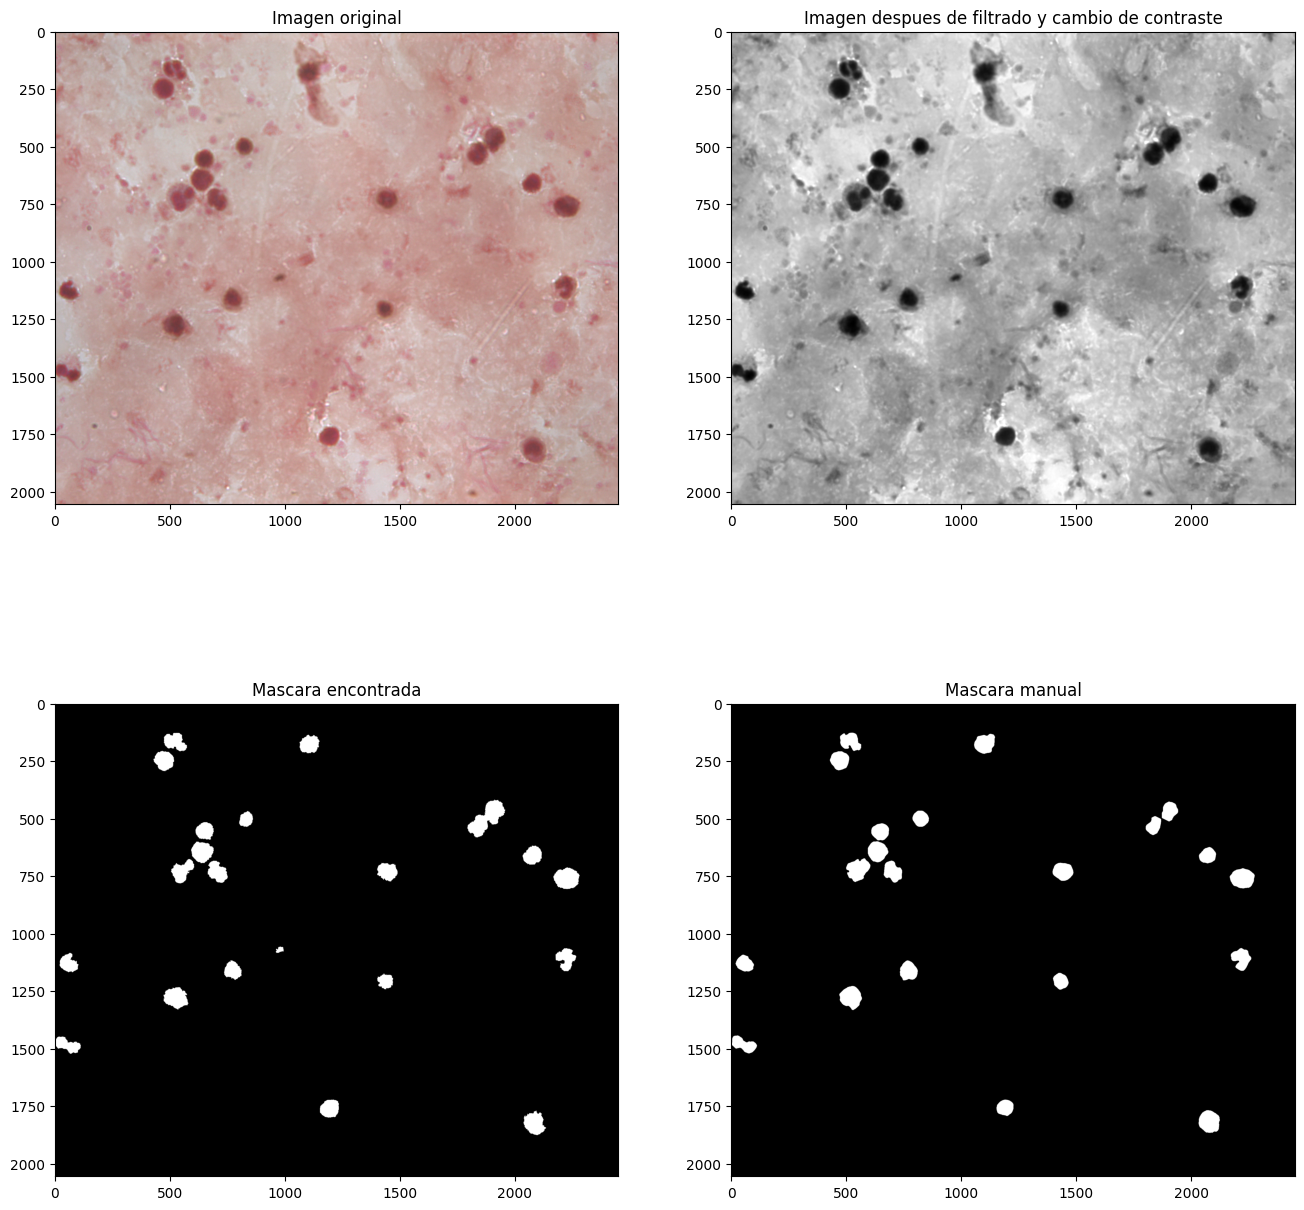

In [28]:
#corremos la imagen
img_proces, mask, cnt = contador_leucositos(img)

#ploteamos
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Imagen original')
plt.imshow(img, cmap='gray')

plt.subplot(222)
plt.title('Imagen despues de filtrado y cambio de contraste')
plt.imshow(img_proces, cmap='gray')

plt.subplot(223)
plt.title('Mascara encontrada')
plt.imshow(mask, cmap='gray')

plt.subplot(224)
plt.title('Mascara manual')
plt.imshow(img_mask, cmap='gray')

plt.show()

## Indice de Jaccard

In [29]:
mask_img_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
[_, mask_img_manual] = cv2.threshold(mask_img_gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Calculamos el IoU o indice de Jaccard
J = jaccard_score(mask_img_manual, mask, average = 'micro')
print("indice de Jaccard", J*100,'%')

indice de Jaccard 81.33963966867567 %
